In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from retirement_engine.simulator import run_simulation, get_annual_withdrawal
from retirement_engine.withdrawal_strategies import pause_after_loss_withdrawal, guardrails_withdrawal

In [3]:

class RetirementSimulator:

    STRATEGIES = {
        "Pause After Loss": pause_after_loss_withdrawal,
        "Guardrails": guardrails_withdrawal,
        "Fixed": fixed_withdrawal,
        "Dynamic": dynamic_withdrawal,
        "Inflation Adjusted": inflation_adjusted,
    }
    
    def __init__(self, returns, strategy, withdrawal_rate, initial_balance=1_000_000, sp500_weight=0.6, days_per_year=365):
        self.returns = returns  # full list of (sp500_r, bonds_r) tuples
        self.strategy = strategy
        self.withdrawal_rate = withdrawal_rate
        self.initial_balance = initial_balance
        self.sp500_weight = sp500_weight
        self.days_per_year = days_per_year

        self.balance_series = []
        self.return_windows = []
        self.withdrawals = []
        self.balances = []

    def compute_blended_return(self, sp500_r, bonds_r):
        try:
            blended = self.sp500_weight * float(sp500_r) + (1 - self.sp500_weight) * float(bonds_r)
            if not isinstance(blended, (int, float)) or blended == float("inf") or blended != blended:
                raise ValueError("Invalid blended return")
            return blended
        except Exception as e:
            print(f"[ERROR] Failed to compute blended return → {sp500_r, bonds_r} → {e}")
            return 0.0

    def simulate_market(self):
        balance = self.initial_balance
        for day in range(len(self.returns)):
            sp500_r, bonds_r = self.returns[day]
            blended_r = self.compute_blended_return(sp500_r, bonds_r)
            balance *= 1 + blended_r

            if day % self.days_per_year == 0:
                self.balance_series.append(balance)
                trailing = self.returns[max(0, day - self.days_per_year):day]
                self.return_windows.append(trailing)

    def apply_strategy(self):
        if self.strategy not in STRATEGIES:
            raise NotImplementedError(f"Strategy '{self.strategy}' not implemented")

        strategy_fn = STRATEGIES[self.strategy]

        # Some strategies need return_windows, some don't
        if self.strategy == "Pause After Loss":
            self.withdrawals = strategy_fn(
                self.balance_series, self.return_windows, self.withdrawal_rate, self.sp500_weight
            )
        else:
            self.withdrawals = strategy_fn(
                self.balance_series, self.withdrawal_rate, self.initial_balance
            )


    def reconstruct_balances(self):
        balance = self.initial_balance
        year_index = 0
        for day in range(len(self.returns)):
            if day % self.days_per_year == 0 and year_index < len(self.withdrawals):
                balance -= self.withdrawals[year_index]
                year_index += 1

            sp500_r, bonds_r = self.returns[day]
            blended_r = self.compute_blended_return(sp500_r, bonds_r)
            balance *= 1 + blended_r
            self.balances.append(balance)

    def run(self):
        self.simulate_market()
        self.apply_strategy()
        self.reconstruct_balances()
        return self.balances, self.withdrawals

In [4]:
def load_market_data(path, sp500_weight=0.6):
    df = pd.read_csv(path)
    df["SP500_return"] = df["SP500"].pct_change()
    df["BONDS_return"] = df["BONDS"].pct_change()
    df = df.dropna()
    return list(zip(df["SP500_return"], df["BONDS_return"]))

In [5]:
returns = load_market_data("data/market.csv")

In [6]:
sim = RetirementSimulator(
    returns=returns,
    strategy="Pause After Loss",
    withdrawal_rate=0.04,
    initial_balance=1_000_000,
    sp500_weight=0.6
)

balances, withdrawals = sim.run()


In [7]:
print(f"Final Balance: ${balances[-1]:,.2f}")
print(f"Total Withdrawn: ${sum(withdrawals):,.2f}")
print(f"Years Simulated: {len(withdrawals)}")

Final Balance: $1,916,767.67
Total Withdrawn: $1,167,420.81
Years Simulated: 16


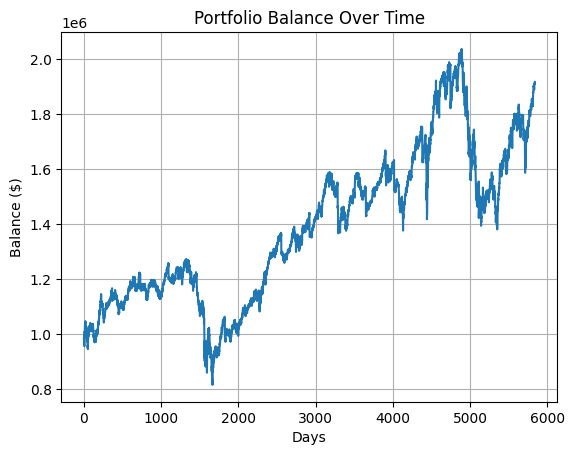

In [8]:
import matplotlib.pyplot as plt

plt.plot(balances)
plt.title("Portfolio Balance Over Time")
plt.xlabel("Days")
plt.ylabel("Balance ($)")
plt.grid(True)
plt.show()

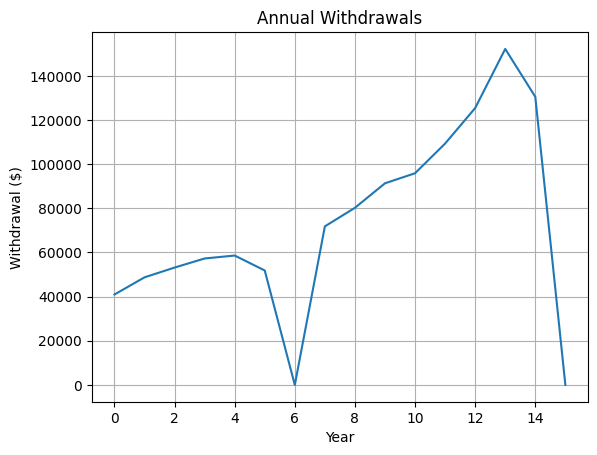

In [9]:
plt.plot([i for i in range(len(withdrawals))], withdrawals)
plt.title("Annual Withdrawals")
plt.xlabel("Year")
plt.ylabel("Withdrawal ($)")
plt.grid(True)
plt.show()

In [10]:
sim = RetirementSimulator(
    returns=returns,
    strategy="Pause After Loss",
    withdrawal_rate=0.04,
    initial_balance=1_000_000,
    sp500_weight=0.6
)

balances, withdrawals = sim.run()

In [12]:
balances, withdrawals = sim.run()

In [13]:
print(f"Final Balance: ${balances[-1]:,.2f}")
print(f"Total Withdrawn: ${sum(withdrawals):,.2f}")
print(f"Years Simulated: {len(withdrawals)}")

Final Balance: $1,916,767.67
Total Withdrawn: $3,502,262.42
Years Simulated: 48


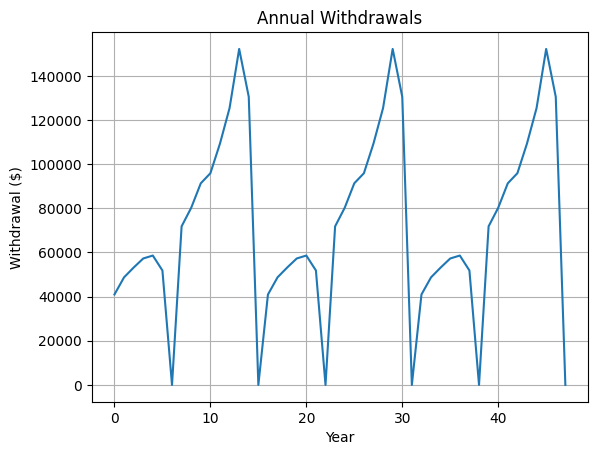

In [14]:
plt.plot([i for i in range(len(withdrawals))], withdrawals)
plt.title("Annual Withdrawals")
plt.xlabel("Year")
plt.ylabel("Withdrawal ($)")
plt.grid(True)
plt.show()